In [1]:
from __future__ import print_function
import argparse
import math
from math import log10
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from dataset import get_training_set, get_test_set
from tiles import tile, untile
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import time
import os
import matplotlib.pyplot as plt
from bmode_visu import bmode_visu
import skimage
from skimage.feature import peak_local_max
import pandas as pd
from new_tiles import new_tile, new_untile
from perf import plot_max, align_by_dist, equal_length, non_predicted, distance_pred_target, distance_nonull, performance_tubes_df 
from graph_perf import accumulation_pos, normalize, accumulation_xpos, graph_amplitude, graph_diff
import re

In [13]:
%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # Have bigger cells in Jupyter Notebook 

In [ ]:
# Settings and hyperparameters
threads = 0
seed = 123

In [ ]:
# Check for cuda
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed(seed)
else:
    device = torch.device("cpu")

In [5]:
# # Test to normalize the data (not successful)
# # 0.1171 - 0.2253 07_noisy / 

# transform = transforms.Compose([
#     transforms.Normalize(0.1171, 0.2253)
# ])
# target_transform = transforms.Compose([
#     transforms.Normalize(0.1171, 0.2253)
# ])

# Data test selection

In [6]:
# Load the test set
# root = '../testing_set_numpy/eval_set_numpy_noisy/eval_set_32x32_batch_20/'
# root = '../testing_set_numpy/testing_perf/eval_set_32x32_batch_30/'
root = '../training_set_np/'

test_set = get_test_set(transform=None, target_transform=None, root = root)
testing_data_loader = DataLoader(dataset=test_set, num_workers=threads, shuffle=False)

# Model selection

In [8]:
#Load the model
model = torch.load("../trained_models/liu/model_07_noise/model_07_noise_5_24.pth")
# model = torch.load("../trained_models/vansloun/model_07_noise/model_07_noise_9_15.pth")
# model = torch.load("../trained_models/rcan/_couture_x4_lr0.0001_btch64_gfilt5_amp10.pth")
model.cuda() # /!\ Remove .cuda() if we don't have cuda available /!\
model.eval()

Net(
  (norma): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (norma1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norma2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norma3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norma4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norma5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), 

# Model on test data

In [27]:
#Predict on all test data
criterion = nn.MSELoss().cuda()
predictions = []
inputs =  []
targets = [] 
mse = []
for batch in testing_data_loader:
    with torch.no_grad():
        model.eval()
        batch = batch
        input, target = Variable(batch[0].float()).cuda(), Variable(batch[1].float()).cuda() # /!\ Remove .cuda() if we don't have cuda available /!\
        prediction = model(input)
        predictions.append(prediction)
        inputs.append(input)
        targets.append(target)
        #mse.append(criterion(prediction, target).item())
        #psnr = 10 * log10(amplitude / mse.item())
        #avg_psnr += psnr

# Peak Local Max of Predicted

In [28]:
#Improve the localization using local_maxima estimation and threshold
coordinates = []
for i in range(len(predictions)):
    for j in range(len(predictions[i])):
        coordinates.append(peak_local_max(predictions[i][j,0,:,:].cpu().detach().numpy(), threshold_abs= 2, min_distance = 2))
        predictions_lmax = np.zeros((128,128,len(coordinates)))

for k in range(len(coordinates)):
    predictions_lmax[coordinates[k][:,0], coordinates[k][:,1], k] = 1      


# Visualization

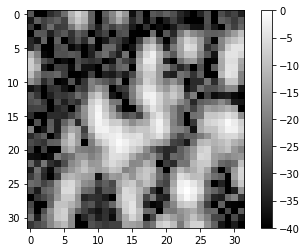

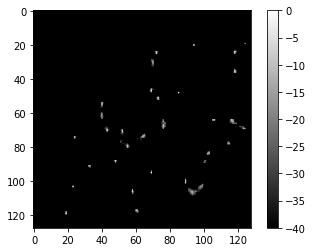

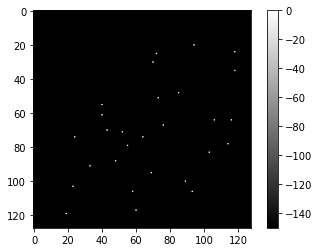

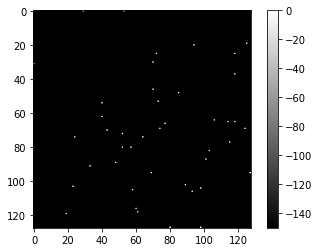

In [9]:
# Look at the input, prediction, prediction_lmax, target for a specified range
for i in range(270,271):
    for j in range(predictions[i].size()[0]):
        bmode_visu(inputs[i][j,0,:,:].cpu().detach().numpy()) # /!\ Remove .cpu() if we don't have cuda available /!\
        bmode_visu(predictions[i][j,0,:,:].cpu().detach().numpy()) # /!\ Remove .cpu() if we don't have cuda available /!\
        bmode_visu(predictions_lmax[:,:,i],150)
        bmode_visu(targets[i][j,0,:,:].cpu().detach().numpy(), 150) # /!\ Remove .cpu() if we don't have cuda available /!\

## Tubes and Couture

In [10]:
# Loading a .mat file and save it to a .npz file
import numpy as np
import scipy.io
from pathlib import Path

data = scipy.io.loadmat('../DL_flow/multiflow_DL_c_30_snr5.mat') # Tubes
# data = scipy.io.loadmat('../DL_flow/IQ_couture.mat') # Couture

flow_set  = data['IQc'] # Tubes
# flow_set  = data['absSf'] # Couture
dirac_all = data['dirac_truth'] # Tubes

np.savez('../DL_flow/flow_simu_raw.npz', flow_set) # Tubes
# np.savez('../DL_flow/flow_simu_raw_2.npz', flow_set) # Couture
np.savez('../DL_flow/flow_simu_truth.npz', dirac_all) # Tubes

In [9]:
# Couture
container_raw = np.load('../DL_flow/flow_simu_raw_2.npz')
IQc_raw = np.array([container_raw[key] for key in container_raw])
IQc_tiled_raw, nz_tiles, nx_tiles = new_tile(IQc_raw[0][0:64,:,], 32)

In [5]:
# Tubes
# Load .npz file and split raw and truth part in numpy array
container_raw = np.load('../DL_flow/flow_simu_raw.npz')
IQc_raw = np.array([container_raw[key] for key in container_raw]).squeeze()
container_truth = np.load('../DL_flow/flow_simu_truth.npz')
IQc_truth = np.array([container_truth[key] for key in container_truth]).squeeze()

IQc_tiled_raw, nz_tiles, nx_tiles = new_tile(IQc_raw, 32)

In [6]:
# Predict on tiled image with the model and reconstruct each image with untile
predictions = torch.Tensor().cuda()
for batch in IQc_tiled_raw:
    with torch.no_grad():
        input = Variable(batch.unsqueeze(0).float()).cuda()
        prediction = model(input)
        predictions = torch.cat((predictions, prediction))
prediction_untiled = new_untile(predictions, Nz = 2, Nx = 2, nz_tiles = nz_tiles, nx_tiles = nx_tiles, SR = 4) # Tubes
# prediction_untiled = new_untile(predictions, Nz = 2, Nx = 4, nz_tiles = nz_tiles, nx_tiles = nx_tiles, SR = 4) # Couture

In [7]:
prediction_norma = np.empty_like(prediction_untiled.cpu().detach().numpy())
for i in range(len(prediction_untiled.cpu().detach().numpy())):
    prediction_norma[i,0,:,:] = prediction_untiled.cpu().detach().numpy()[i,0,:,:] / np.max(prediction_untiled.cpu().detach().numpy()[i,0,:,:]) 

## Peak Local Max

In [8]:
# Peak Local Max after Untile
# Improve the localization using local_maxima estimation and threshold
coordinates_tile = []
for i in range(800):
    for j in range(len(predictions[i])):
        coordinates_tile.append(peak_local_max(prediction_untiled[i,0,:,:].cpu().detach().numpy(), threshold_abs= 2, min_distance = 4)) #, num_peaks = 40
predictions_tile_lmax = np.zeros((256,256,len(coordinates_tile))) # Tubes
# predictions_tile_lmax = np.zeros((256,512,len(coordinates_tile))) # Couture

for k in range(len(coordinates_tile)):
    predictions_tile_lmax[coordinates_tile[k][:,0], coordinates_tile[k][:,1], k] = 1

## Save Predictions

In [9]:
np.save('../predictions/tubes/rcan/prediction.npy', prediction_untiled.cpu().detach().numpy().squeeze())
np.save('../predictions/tubes/rcan/prediction_plm.npy', predictions_tile_lmax)
np.save('../predictions/tubes/rcan/prediction_norma.npy', prediction_norma.squeeze())
# np.save('../predictions/tubes/target.npy', IQc_truth)

## Load Predictions and Target

In [3]:
target = np.load('../predictions/tubes/target.npy')

prediction_liu = np.load('../predictions/tubes/liu/prediction.npy')
prediction_plm_liu = np.load('../predictions/tubes/liu/prediction_plm.npy')
prediction_norma_liu = np.load('../predictions/tubes/liu/prediction_norma.npy')

prediction_vansloun = np.load('../predictions/tubes/vansloun/prediction.npy')
prediction_plm_vansloun = np.load('../predictions/tubes/vansloun/prediction_plm.npy')
prediction_norma_vansloun = np.load('../predictions/tubes/vansloun/prediction_norma.npy')

prediction_rcan = np.load('../predictions/tubes/rcan/prediction.npy')
prediction_plm_rcan = np.load('../predictions/tubes/rcan/prediction_plm.npy')
prediction_norma_rcan = np.load('../predictions/tubes/rcan/prediction_norma.npy')

## Accumulation of the position for Nt images

In [4]:
s_target = np.sum(target, axis = 2)
s_pred_rcan, s_pred_plm_rcan, s_pred_norma_rcan = accumulation_pos(prediction_rcan, prediction_plm_rcan, prediction_norma_rcan)
s_pred_liu, s_pred_plm_liu, s_pred_norma_liu = accumulation_pos(prediction_liu, prediction_plm_liu, prediction_norma_liu)
s_pred_vansloun, s_pred_plm_vansloun, s_pred_norma_vansloun = accumulation_pos(prediction_vansloun, prediction_plm_vansloun, prediction_norma_vansloun)

## Accumulation X position

In [5]:
xsum_target = np.sum(s_target, axis = 0)
xsum_pred_rcan, xsum_pred_plm_rcan, xsum_pred_norma_rcan = accumulation_xpos(s_pred_rcan, s_pred_plm_rcan, s_pred_norma_rcan)
xsum_pred_liu, xsum_pred_plm_liu, xsum_pred_norma_liu = accumulation_xpos(s_pred_liu, s_pred_plm_liu, s_pred_norma_liu)
xsum_pred_vansloun, xsum_pred_plm_vansloun, xsum_pred_norma_vansloun = accumulation_xpos(s_pred_vansloun, s_pred_plm_vansloun, s_pred_norma_vansloun)

## Normalize the accumulation

In [6]:
norm_xsum_target = xsum_target / np.max(xsum_target)
norm_xsum_pred_rcan, norm_xsum_pred_plm_rcan, norm_xsum_pred_norma_rcan = normalize(xsum_pred_rcan, xsum_pred_plm_rcan, xsum_pred_norma_rcan)
norm_xsum_pred_liu, norm_xsum_pred_plm_liu, norm_xsum_pred_norma_liu = normalize(xsum_pred_liu, xsum_pred_plm_liu, xsum_pred_norma_liu)
norm_xsum_pred_vansloun, norm_xsum_pred_plm_vansloun, norm_xsum_pred_norma_vansloun = normalize(xsum_pred_vansloun, xsum_pred_plm_vansloun, xsum_pred_norma_vansloun)

## Graph Amplitude Tubes

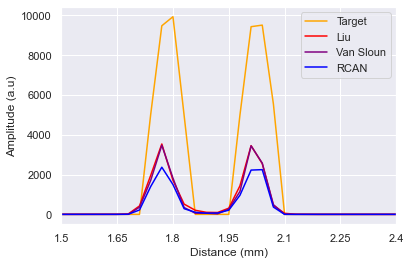

In [12]:
graph_amplitude(xsum_target, xsum_pred_plm_liu, xsum_pred_plm_vansloun, xsum_pred_plm_rcan) 

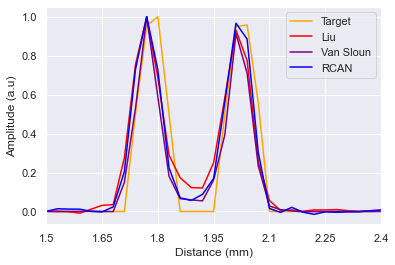

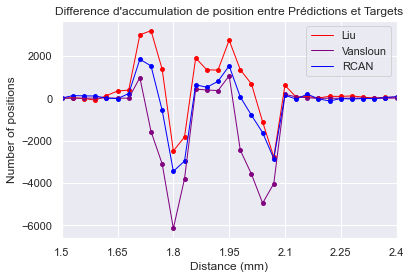

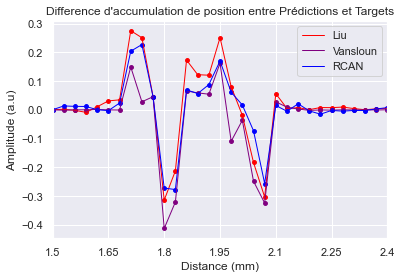

In [9]:
ylabel = "Number of Positions"
ylabel_2 = "Amplitude (a.u.)"
title = "Différence d'accumulation de position entre Prédictions et Targets"
title_2 = "Différence d'amplitude entre Prédictions et Targets"
graph_amplitude(norm_xsum_target, norm_xsum_pred_liu, norm_xsum_pred_vansloun, norm_xsum_pred_rcan)
graph_diff(xsum_target, xsum_pred_norma_liu, xsum_pred_norma_vansloun, xsum_pred_norma_rcan, Ylabel = ylabel, Title = title) 
graph_diff(norm_xsum_target, norm_xsum_pred_liu, norm_xsum_pred_vansloun, norm_xsum_pred_rcan, Ylabel = ylabel_2, Title = title)

## How much % of the tubes reconstructed

In [4]:
raww = np.load('../tube_perf/simus_mat/np_x4/raw/multiflow_DL_x4_c_47_snr20_dist0.0001_raw.npy')
truthh = np.load('../tube_perf/simus_mat/np_x4/truth/multiflow_DL_x4_c_47_snr20_dist0.0001_truth.npy')

raww_tiled , nz_tiles, nx_tiles = new_tile(raww, 32)

In [5]:
truthh_s = np.sum(truthh, axis = 2)

In [6]:
counter = 0
truth_coord = []
for i in range(len(truthh_s[0])):
    for j in range(len(truthh_s[1])):
        if truthh_s[i,j] != 0:
            truth_coord.append([i,j]) # Liste des coordonnés de la target
            counter += 1 # Nombre de coordonnés à prédire

In [7]:
predictions = torch.Tensor().cuda()
for batch in raww_tiled:
    with torch.no_grad():
        input = Variable(batch.unsqueeze(0).float()).cuda()
        prediction = vansloun_m(input)
        predictions = torch.cat((predictions, prediction))
prediction_untiled = new_untile(predictions, Nz = 2, Nx = 2, nz_tiles = nz_tiles, nx_tiles = nx_tiles, SR = 4)

In [8]:
coordinates_tile = []
for h in range(1000):
    coordinates_tile.append(peak_local_max(prediction_untiled[h,0,:,:].cpu().detach().numpy(), threshold_abs = 1, min_distance = 4)) 
prediction_plm_liu = np.zeros((256,256,len(coordinates_tile)))

for k in range(len(coordinates_tile)):
            prediction_plm_liu[coordinates_tile[k][:,0], coordinates_tile[k][:,1], k] = 1

In [11]:
diff_counter = 0 # Compteur de positions uniques prédites
c_50 = 0
c_65 = 0

already_checked = [] # Initialiser la liste de position prédites uniques
for i in range(len(coordinates_tile)):
    for j in range(len(coordinates_tile[i])):
        if list(coordinates_tile[i][j]) in truth_coord and list(coordinates_tile[i][j]) not in list(already_checked): # Regarder si la position prédite est unique et si elle est dans la liste de target
            diff_counter +=1 # Augmenter le nombre de position prédite unique
            already_checked.append(list(coordinates_tile[i][j])) # Ajouter la préidiction dans la liste de prédiction unique
            if ((diff_counter / counter) * 100) > 50 and c_50 == 0:
                print("50% of the tubes predict at",i+1,"image")
                c_50 = 1
            if ((diff_counter / counter) * 100) > 65 and c_65 == 0:
                print("65% of the tubes predict at",i+1,"image")
                c_65 = 1
print(((diff_counter / counter) * 100), "% of the tubes predict at",i+1,"image")

50% of the tubes predict at 298 image
65% of the tubes predict at 818 image
66.95852534562212 % of the tubes predict at 1000 image


In [14]:
def plot(T):
    plt.plot(T)

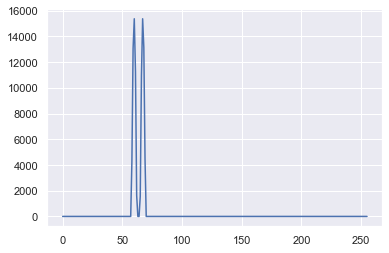

In [21]:
plot(np.sum(truthh_s,axis=0))
plt.savefig('graph.png')

## Tubes different performance

In [3]:
liu_m = torch.load("../trained_models/x4/liu.pth")
liu_m.cuda()
liu_m.eval()
vansloun_m = torch.load("../trained_models/x4/vansloun.pth")
vansloun_m.cuda()
vansloun_m.eval()
rcan_m = torch.load("../trained_models/x4/rcan.pth")
rcan_m.cuda()
rcan_m.eval()

RCAN(
  (head): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResidualGroup(
      (body): Sequential(
        (0): RCAB(
          (body): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): CALayer(
              (avg_pool): AdaptiveAvgPool2d(output_size=1)
              (conv_du): Sequential(
                (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
                (3): Sigmoid()
              )
            )
          )
  

C:\Users\Tutur\Documents\julien_le_giga_bg\python_notebook\graph_perf.py:26: RuntimeWarning: invalid value encountered in true_divide
  norm_xsum_pred_plm = xsum_pred_plm / np.max(xsum_pred_plm)


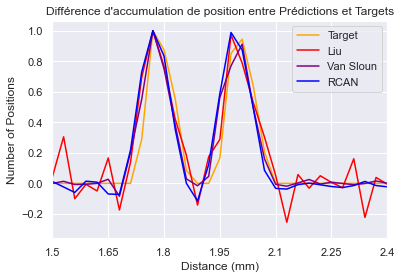

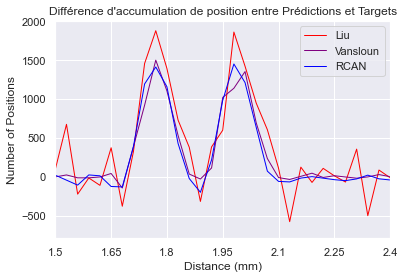

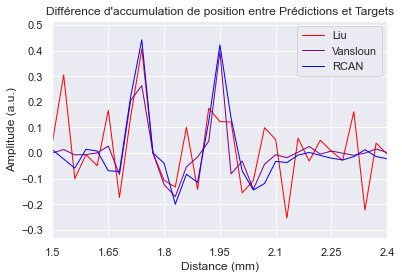

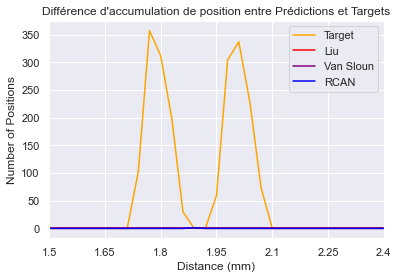

KeyboardInterrupt: 

In [6]:
path_raw = '../tube_perf/simus_mat/np_x4/raw/'
path_truth = '../tube_perf/simus_mat/np_x4/truth/'
path_savefile = '../tube_perf/simus_mat/perf_x4/'

df_temp = pd.DataFrame(columns=['Nom du Model', 'Distance moyenne entre les Mb mal prédites', "Concentration", "Distance entre tubes", "Pourcentage de Mb bien prédites", "Pourcentage de Mb non prédites"])

for (files_raw, files_truth) in zip(os.walk(path_raw, topdown=False), os.walk(path_truth, topdown=False)):
    torch.cuda.empty_cache()
    for (name_raw, name_truth) in zip(files_raw[2], files_truth[2]):
        raw = np.load(path_raw + name_raw) # Tubes
        truth = np.load(path_truth + name_truth) # Tubes
        tiled_raw, nz_tiles, nx_tiles = new_tile(raw, 32)
        
        dist_val = str([int(s) for s in re.findall(r'\d+',name_raw)][3:])
        dist_val = dist_val[1] + dist_val[-2]
        concentration_val = [int(s) for s in re.findall(r'\d+',name_raw)][1]
        
        ############
        
          # LIU #
        
        ############
        
        predictions_liu = torch.Tensor().cuda()
        for batch in tiled_raw:
            with torch.no_grad():
                input = Variable(batch.unsqueeze(0).float()).cuda()
                prediction_liu = liu_m(input)
                predictions_liu = torch.cat((predictions_liu, prediction_liu))
        prediction_untiled = new_untile(predictions_liu, Nz = 2, Nx = 2, nz_tiles = nz_tiles, nx_tiles = nx_tiles, SR = 4)
        prediction_norma = np.empty_like(prediction_untiled.cpu().detach().numpy())
        
        for i in range(len(prediction_untiled.cpu().detach().numpy())):
            prediction_norma[i,0,:,:] = prediction_untiled.cpu().detach().numpy()[i,0,:,:] / np.max(prediction_untiled.cpu().detach().numpy()[i,0,:,:])
        
        coordinates_tile = []
        for h in range(1000):
            coordinates_tile.append(peak_local_max(prediction_untiled[h,0,:,:].cpu().detach().numpy(), threshold_abs = 1, min_distance = 4)) 
        prediction_plm_liu = np.zeros((256,256,len(coordinates_tile)))

        for k in range(len(coordinates_tile)):
            prediction_plm_liu[coordinates_tile[k][:,0], coordinates_tile[k][:,1], k] = 1
            
        prediction_liu = prediction_untiled.cpu().detach().numpy().squeeze()
        prediction_norma_liu = prediction_norma.squeeze()
        
        ############
        
        # VANSLOUN #
        
        ############
        
        predictions_vansloun = torch.Tensor().cuda()
        for batch in tiled_raw:
            with torch.no_grad():
                input = Variable(batch.unsqueeze(0).float()).cuda()
                prediction_vansloun = vansloun_m(input)
                predictions_vansloun = torch.cat((predictions_vansloun, prediction_vansloun))
        prediction_untiled = new_untile(predictions_vansloun, Nz = 2, Nx = 2, nz_tiles = nz_tiles, nx_tiles = nx_tiles, SR = 4)
        prediction_norma = np.empty_like(prediction_untiled.cpu().detach().numpy())
        
        for i in range(len(prediction_untiled.cpu().detach().numpy())):
            prediction_norma[i,0,:,:] = prediction_untiled.cpu().detach().numpy()[i,0,:,:] / np.max(prediction_untiled.cpu().detach().numpy()[i,0,:,:])
        
        coordinates_tile = []
        for h in range(1000):
            coordinates_tile.append(peak_local_max(prediction_untiled[h,0,:,:].cpu().detach().numpy(), threshold_abs= 1, min_distance = 4)) 
        prediction_plm_vansloun = np.zeros((256,256,len(coordinates_tile)))

        for k in range(len(coordinates_tile)):
            prediction_plm_vansloun[coordinates_tile[k][:,0], coordinates_tile[k][:,1], k] = 1
            
        prediction_vansloun = prediction_untiled.cpu().detach().numpy().squeeze()
        prediction_norma_vansloun = prediction_norma.squeeze()
        
        ############
        
          # RCAN #
            
        ############
        
        predictions_rcan = torch.Tensor().cuda()
        for batch in tiled_raw:
            with torch.no_grad():
                input = Variable(batch.unsqueeze(0).float()).cuda()
                prediction_rcan = rcan_m(input)
                predictions_rcan = torch.cat((predictions_rcan, prediction_rcan))
        prediction_untiled = new_untile(predictions_rcan, Nz = 2, Nx = 2, nz_tiles = nz_tiles, nx_tiles = nx_tiles, SR = 4)
        prediction_norma = np.empty_like(prediction_untiled.cpu().detach().numpy())
        
        for i in range(len(prediction_untiled.cpu().detach().numpy())):
            prediction_norma[i,0,:,:] = prediction_untiled.cpu().detach().numpy()[i,0,:,:] / np.max(prediction_untiled.cpu().detach().numpy()[i,0,:,:])
        
        coordinates_tile = []
        for h in range(1000):
            coordinates_tile.append(peak_local_max(prediction_untiled[h,0,:,:].cpu().detach().numpy(), threshold_abs= 1, min_distance = 4)) 
        prediction_plm_rcan = np.zeros((256,256,len(coordinates_tile)))

        for k in range(len(coordinates_tile)):
            prediction_plm_rcan[coordinates_tile[k][:,0], coordinates_tile[k][:,1], k] = 1
            
        prediction_rcan = prediction_untiled.cpu().detach().numpy().squeeze()
        prediction_norma_rcan = prediction_norma.squeeze()
        
        ### SUMS ###
        
        s_target = np.sum(truth, axis = 2)
        s_pred_rcan, s_pred_plm_rcan, s_pred_norma_rcan = accumulation_pos(prediction_rcan, prediction_plm_rcan, prediction_norma_rcan)
        s_pred_liu, s_pred_plm_liu, s_pred_norma_liu = accumulation_pos(prediction_liu, prediction_plm_liu, prediction_norma_liu)
        s_pred_vansloun, s_pred_plm_vansloun, s_pred_norma_vansloun = accumulation_pos(prediction_vansloun, prediction_plm_vansloun, prediction_norma_vansloun)
        
        xsum_target = np.sum(s_target, axis = 0)
        xsum_pred_rcan, xsum_pred_plm_rcan, xsum_pred_norma_rcan = accumulation_xpos(s_pred_rcan, s_pred_plm_rcan, s_pred_norma_rcan)
        xsum_pred_liu, xsum_pred_plm_liu, xsum_pred_norma_liu = accumulation_xpos(s_pred_liu, s_pred_plm_liu, s_pred_norma_liu)
        xsum_pred_vansloun, xsum_pred_plm_vansloun, xsum_pred_norma_vansloun = accumulation_xpos(s_pred_vansloun, s_pred_plm_vansloun, s_pred_norma_vansloun)
        
        norm_xsum_target = xsum_target / np.max(xsum_target)
        norm_xsum_pred_rcan, norm_xsum_pred_plm_rcan, norm_xsum_pred_norma_rcan = normalize(xsum_pred_rcan, xsum_pred_plm_rcan, xsum_pred_norma_rcan)
        norm_xsum_pred_liu, norm_xsum_pred_plm_liu, norm_xsum_pred_norma_liu = normalize(xsum_pred_liu, xsum_pred_plm_liu, xsum_pred_norma_liu)
        norm_xsum_pred_vansloun, norm_xsum_pred_plm_vansloun, norm_xsum_pred_norma_vansloun = normalize(xsum_pred_vansloun, xsum_pred_plm_vansloun, xsum_pred_norma_vansloun)
        
        ### GRAPH GENERATION ###
        
        ylabel = "Number of Positions"
        ylabel_2 = "Amplitude (a.u.)"
        title = "Différence d'accumulation de position entre Prédictions et Targets"
        title_2 = "Différence d'amplitude entre Prédictions et Targets"
        title_3 = "Amplitude d'intensité des pixels"
        title_4 = "Accumulation of position of Peak Local Max of the Predictions"

        graph_diff(xsum_target, xsum_pred_norma_liu, xsum_pred_norma_vansloun, xsum_pred_norma_rcan, Ylabel = ylabel, Title = title)
        plt.savefig(path_savefile + 'diff_acc_pos_pred_norma_c_' + str(concentration_val) + '_d_' + dist_val + '.png')
        graph_diff(norm_xsum_target, norm_xsum_pred_liu, norm_xsum_pred_vansloun, norm_xsum_pred_rcan, Ylabel = ylabel_2, Title = title_2)
        plt.savefig(path_savefile + 'diff_amp_pred_c_' + str(concentration_val) + '_d_' + dist_val + '.png')
        
        graph_amplitude(norm_xsum_target, norm_xsum_pred_liu, norm_xsum_pred_vansloun, norm_xsum_pred_rcan, Ylabel = ylabel_2, Title = title_3)
        plt.savefig(path_savefile + 'amp_intensite_c_' + str(concentration_val) + '_d_' + dist_val + '.png')
        graph_amplitude(xsum_target, xsum_pred_plm_liu, xsum_pred_plm_vansloun, xsum_pred_plm_rcan, Ylabel = ylabel, Title = title_4)
        plt.savefig(path_savefile + 'acc_pos_pred_plm_c_' + str(concentration_val) + '_d_' + dist_val + '.png')

        ### PERF DATAFRAME ###
        
        mean_dist_bp_mb_liu, perc_wp_liu, perc_np_liu = performance_tubes_df(truth, prediction_plm_liu)
        mean_dist_bp_mb_vansloun, perc_wp_vansloun, perc_np_vansloun = performance_tubes_df(truth, prediction_plm_vansloun)
        mean_dist_bp_mb_rcan, perc_wp_rcan, perc_np_rcan = performance_tubes_df(truth, prediction_plm_rcan)

        df_temp.loc[1] = ["liu"] + [mean_dist_bp_mb_liu] + [concentration_val] + [dist_val] + [perc_wp_liu] + [perc_np_liu]
        df_temp.loc[2] = ["vansloun"] + [mean_dist_bp_mb_vansloun] + [concentration_val] + [dist_val] + [perc_wp_vansloun] + [perc_np_vansloun]
        df_temp.loc[3] = ["rcan"] + [mean_dist_bp_mb_rcan] + [concentration_val] + [dist_val] + [perc_wp_rcan] + [perc_np_rcan]
        
        path_df = path_savefile + 'df_perf_c_' + concentration_val + '_dist_' + dist_val + '.csv'
        df_temp.to_csv(path_df,index=False)

In [ ]:
graph_amplitude

## Performance DataFrame

In [16]:
path_csv = '../tube_perf/simus_mat/perf_x4/'
df = pd.DataFrame()
for name_df in os.walk(path_csv, topdown=False):
    for df_csv in name_df[2]:
        load_df = pd.read_csv(path_csv + df_csv)
        df = pd.concat([df, load_df])

In [143]:
# Plot the 3D graph with the parameter wanted
import plotly.express as px 

fig = px.scatter_3d(df, x = 'Concentration', y = 'Pourcentage de Mb non prédites', z = 'Distance entre tubes', color = 'Nom du Model')
fig.show()

# Clean the memory

In [144]:
import GPUtil
import gc
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated())
GPUtil.showUtilization()
gc.collect()
torch.cuda.empty_cache()
print(torch.cuda.empty_cache())
print(torch.cuda.memory_reserved())
print(torch.cuda.memory_allocated())
GPUtil.showUtilization()

1545601024
1529488384
| ID | GPU | MEM |
------------------
|  0 |  0% | 59% |
None
1545601024
1529488384
| ID | GPU | MEM |
------------------
|  0 | 11% | 59% |


In [ ]:
# del model